In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib

In [3]:
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
import numpy as np

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [6]:
import sys
sys.path.append("..")

In [7]:
from mc_plot_utils import MCMCResult
import mc_plot_utils

In [8]:
from scipy.stats import binned_statistic

In [9]:
def load_model(filename):
    model = mc_plot_utils.MCMCResult.from_file(filename)
    binned_model = pd.read_csv(f"../../models/perturbations/mc_analysis/{filename}/2d_binned.csv")

    return binned_model, model.samples, model.labels

In [10]:
def plot_all(filename):
    model, samples, labels = load_model(filename)
    plot_mean_ahfe(model, samples, labels)
    plot_mean_ahfe(model, samples, labels, mode="residual")
    plot_mean_ahfe(model, samples, labels, mode="zscore")
    

In [11]:
def plot_mean_ahfe(afeh, samples, labels, mode='mean', **kwargs):
    fig, ax = plt.subplots()
    ax.set_xlabel("[Mg/H]")
    ax.set_ylabel("[Mg/Fe]")

    p, color_values = plot_mean_ahfe_(ax, afeh, samples, labels, mode=mode, **kwargs)

    if mode == 'residual':
        color_label = "Delta [C/Mg]"
    elif mode == 'zscore':
        color_label = "z score"
    else:
        color_label = "[C/Mg]"

    cbar = plt.colorbar(p, ax=ax)
    cbar.set_label(color_label)

    return fig

In [12]:
def to_brak(c_mg):
    return gcem.abund_ratio_to_brak(c_mg, "c", "mg")

In [13]:
def plot_mean_ahfe_(ax, afeh, samples, labels, thin=10, color='black', alpha=None,
                    colorrange=None, mode='mean'):
    # Compute the mean parameter values
    alpha_mean = np.mean(samples.loc[:, labels], axis=0)

    x, y = afeh['_x'], afeh['_y']
    if mode == "mean":
        print(alpha_mean)
    # Linear combination model
    y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))

    # Determine color range
    if colorrange is None:
        cmin = min(np.min(y_model), np.min(afeh['obs']))
        cmax = max(np.max(y_model), np.max(afeh['obs']))
        colorrange = (to_brak(cmin), to_brak(cmax))

    # Scatter plot based on mode
    if mode == 'residual':
        res = to_brak(afeh['obs']) - to_brak(y_model)
        resmax = np.maximum(0.1, np.max(np.abs(res)))
        if resmax > 0.1:
            print("warning: residual > 0.1")
        p = ax.scatter(afeh['_x'], afeh['_y'], s=100, c=res, cmap='RdBu',
                       vmin=-resmax, vmax=resmax)

        return p, res

    elif mode == 'zscore':
        sy = afeh['obs_err'] / np.sqrt(afeh['obs_counts'])
        sy_model = sum(alpha_mean[i]**2 * afeh[f"{label}_err"] / np.sqrt(afeh[f"_counts"])
                       for i, label in enumerate(labels))
        sy_total = np.sqrt(sy**2 + sy_model**2)
        res = (afeh['obs'] - y_model) / sy_total
        resmax = np.max(np.abs(res))
        p = ax.scatter(afeh['_x'], afeh['_y'], s=100, c=res, cmap='RdBu',
                       vmin=-resmax, vmax=resmax)


        print("chi2 reduced = ", np.mean(res**2))
        return p, res

    elif mode == 'mean':
        c = to_brak(afeh['obs'])
        ax.scatter(x, y, s=100, c=c, vmin=colorrange[0], vmax=colorrange[1])
        ax.scatter(x, y, s=50, c='white')
        c = to_brak(y_model)
        p = ax.scatter(x, y, s=30, c=c, 
                       vmin=colorrange[0], vmax=colorrange[1])

        return p, y_model

    else:
        raise ValueError("Invalid mode. Use 'mean', 'residual', or 'zscore'.")

In [14]:
model, samples, labels = load_model("fiducial")

length of samples =  48000


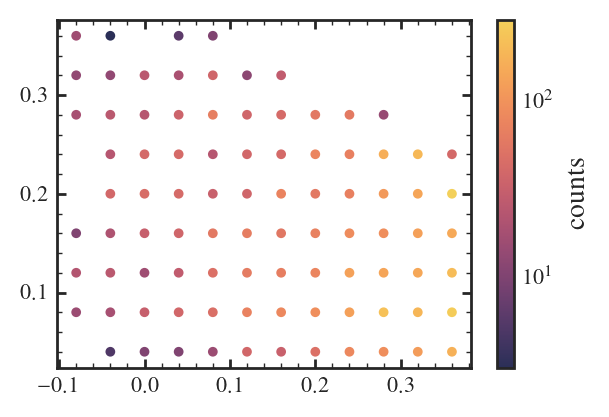

In [15]:
plt.scatter(model._x, model._y, c=model._counts, norm=matplotlib.colors.LogNorm())
plt.colorbar(label = "counts")

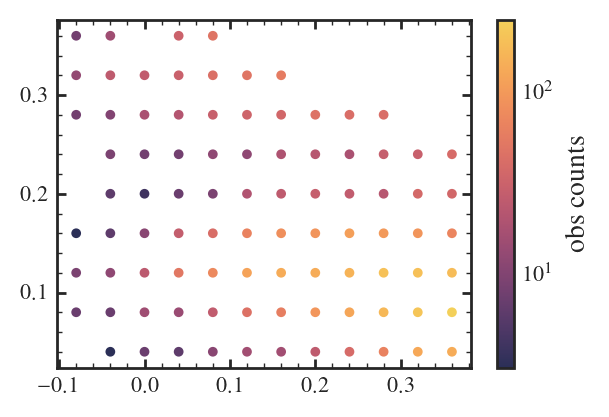

In [16]:
plt.scatter(model._x, model._y, c=model.obs_counts, norm=matplotlib.colors.LogNorm())
plt.colorbar(label = "obs counts")

Text(0, 0.5, '[Mg/Fe]')

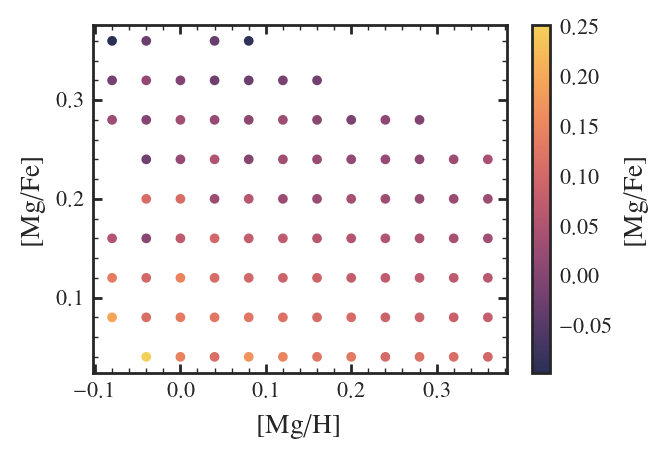

In [17]:
plt.scatter(model._x, model._y, c=to_brak(model.obs))
plt.colorbar(label = "[Mg/Fe]")
plt.xlabel("[Mg/H]")
plt.ylabel("[Mg/Fe]")

length of samples =  48000
alpha      2.406554
y0_cc      1.897160
zeta_cc    2.272786
A_cc       2.586457
dtype: float64
chi2 reduced =  3.12765438956699


/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i]

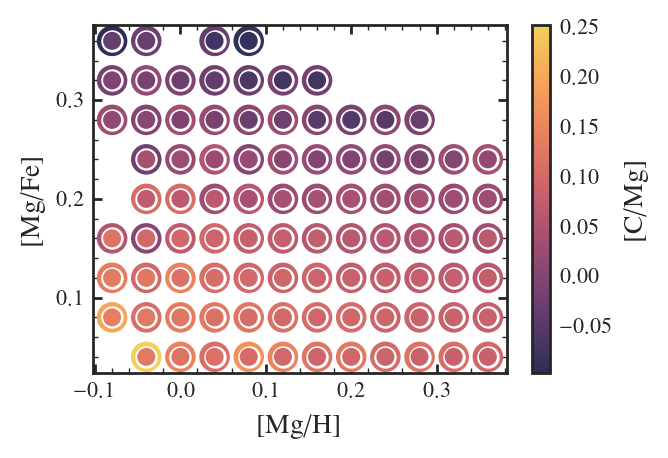

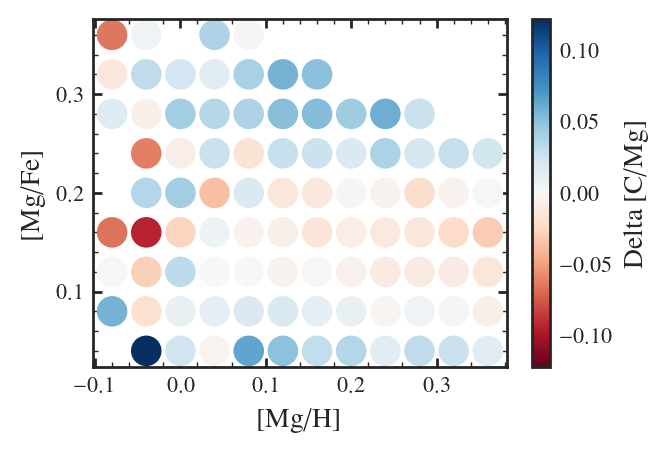

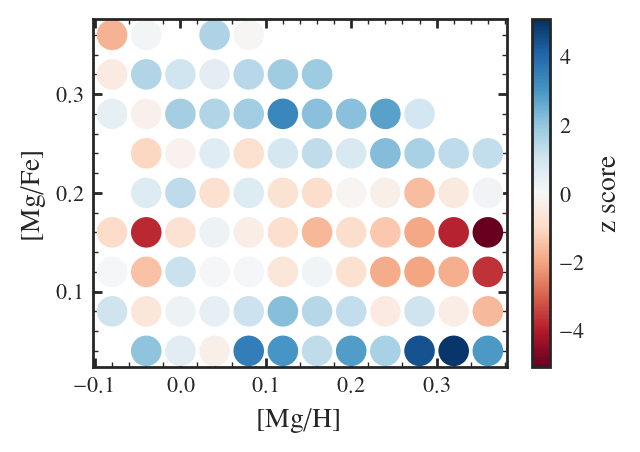

In [18]:
plot_all("fiducial")

length of samples =  48000
alpha      1.866680
y0_cc      1.923239
zeta_cc    0.778258
A_cc       0.844667
dtype: float64
chi2 reduced =  4.808057982550039


/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i]

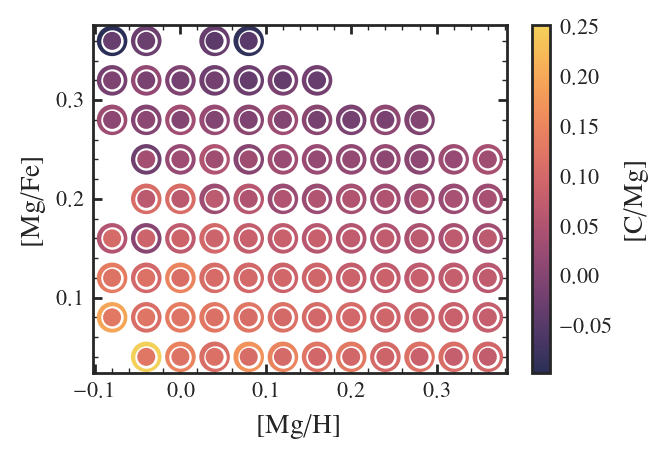

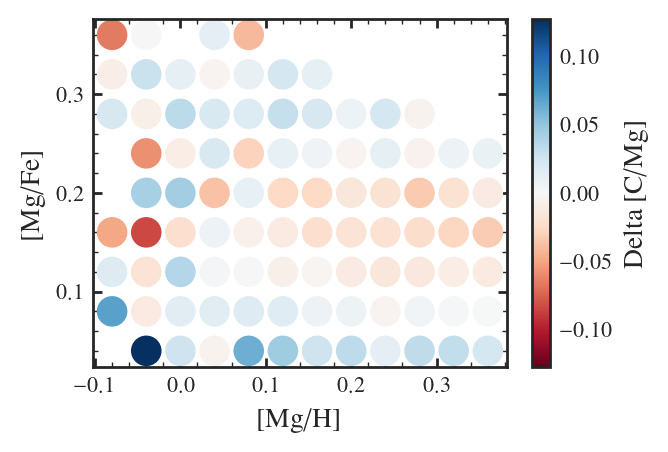

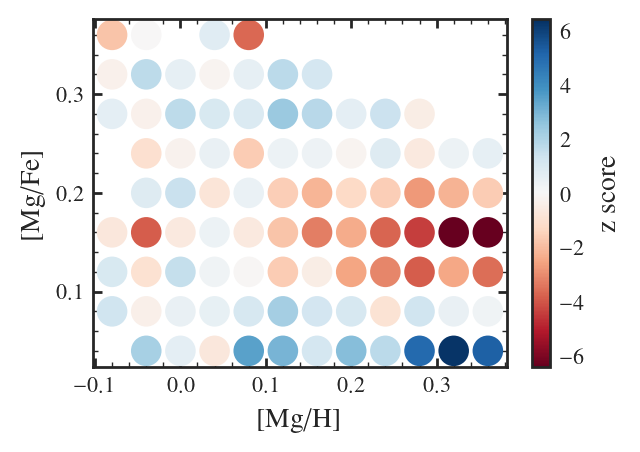

In [19]:
plot_all("fiducial_2d")


length of samples =  48000
alpha      2.011509
y0_cc      1.979657
zeta_cc    1.798662
A_cc       2.080376
dtype: float64
chi2 reduced =  3.60278806412647


/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i]

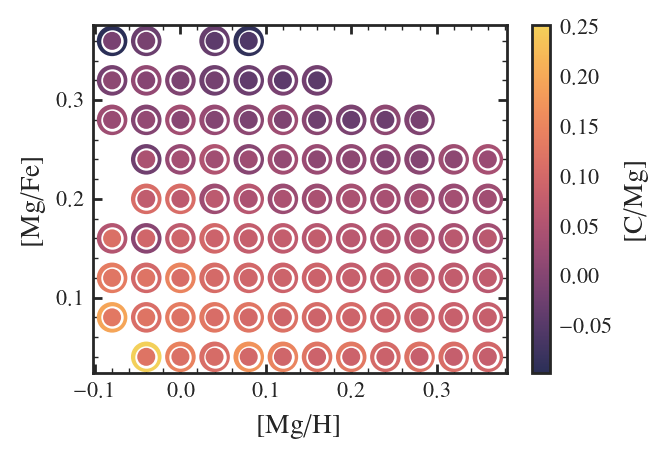

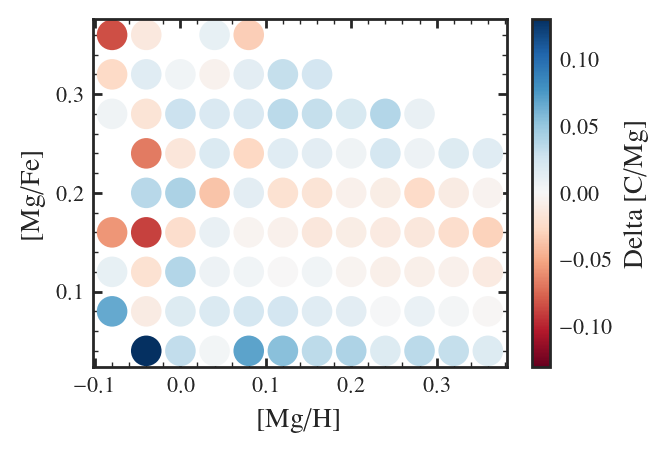

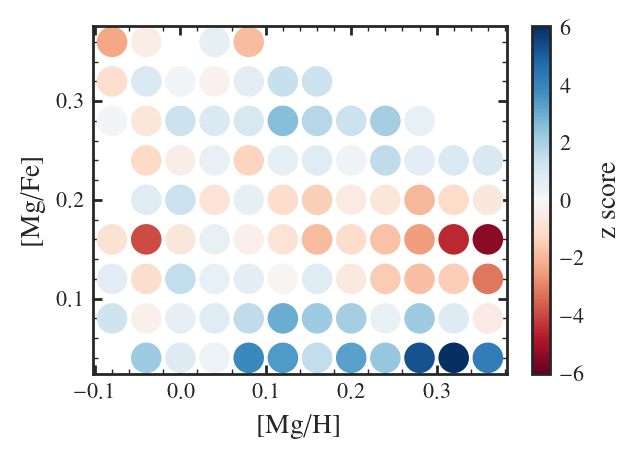

In [20]:
plot_all("fiducial_2d_nosigma")


length of samples =  48000
alpha      1.485537
y0_cc      1.927045
zeta_cc   -0.891026
A_cc      -0.874468
dtype: float64
chi2 reduced =  2.563164205354814


/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i]

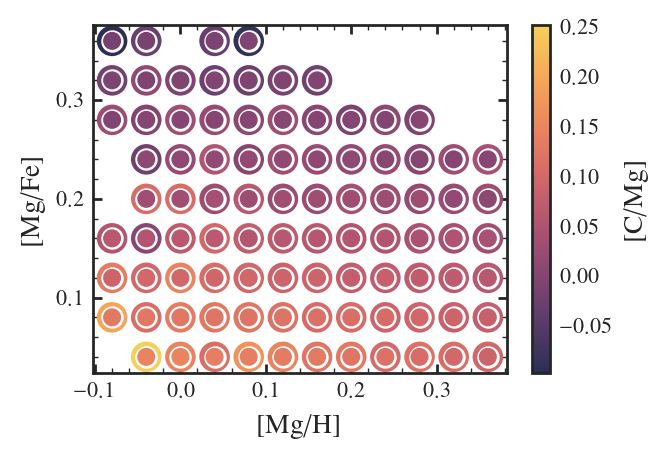

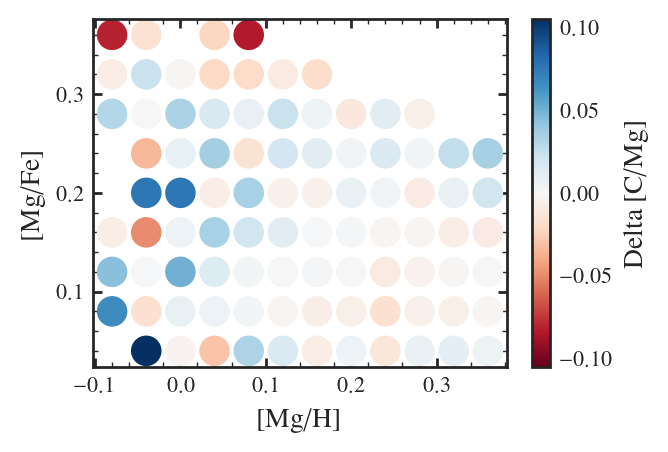

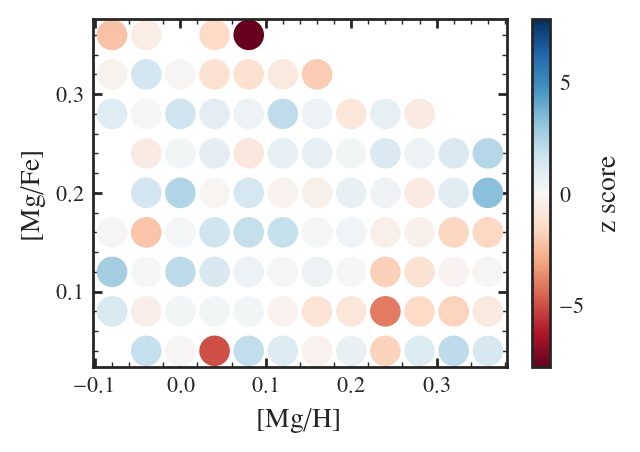

In [21]:
plot_all("fruity_mf0.7_2d")


adding  alpha
length of samples =  48000
y0_cc      1.559089
zeta_cc    0.007034
dtype: float64
chi2 reduced =  521.5099457656565


/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_65111/1110428134.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i]

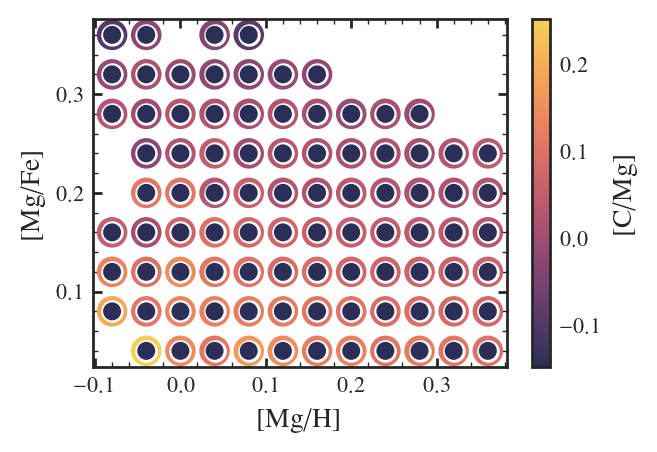

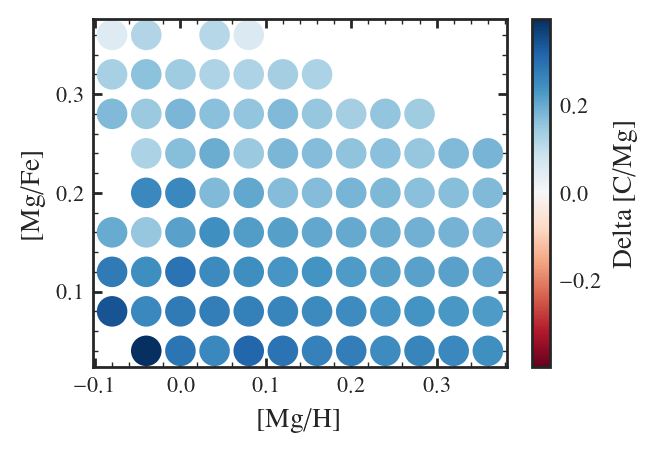

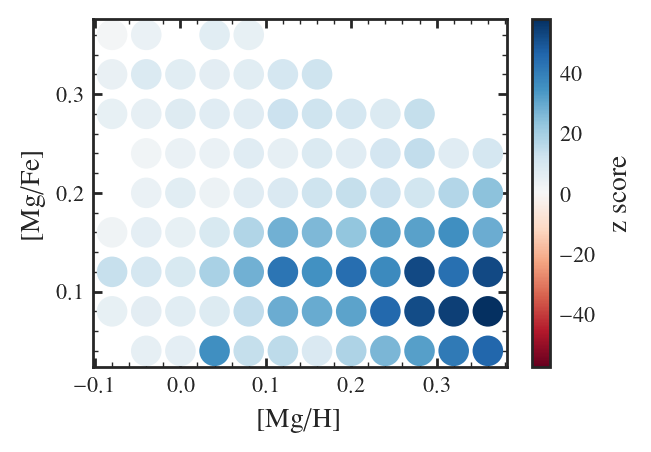

In [23]:
plot_all("fruity_lin_2d")
